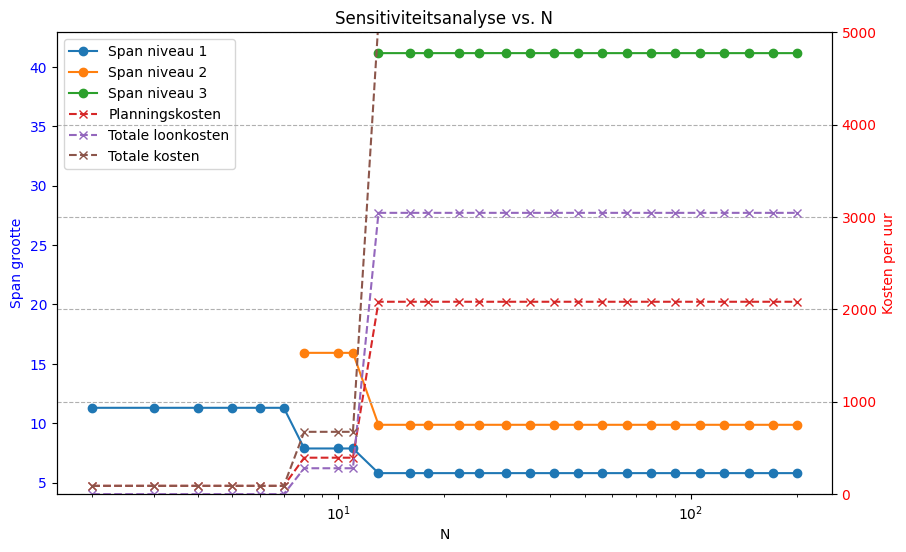

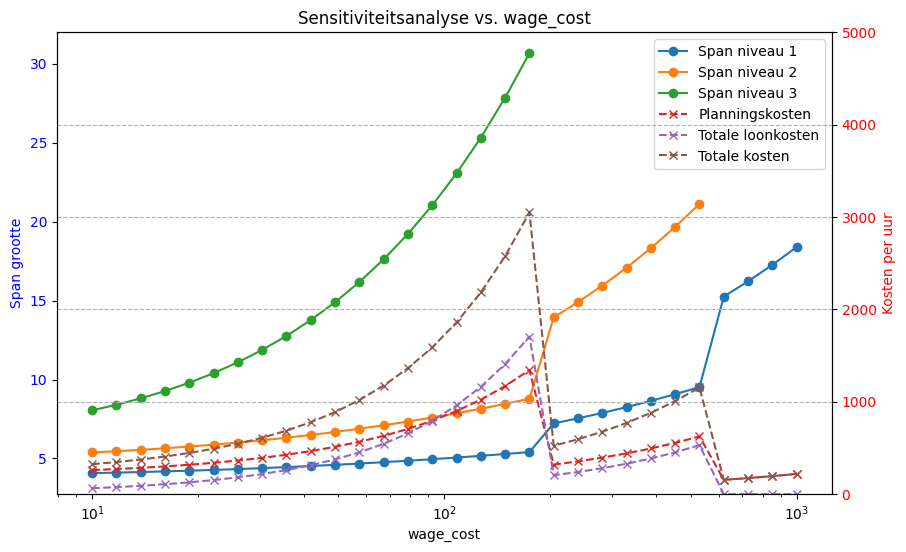

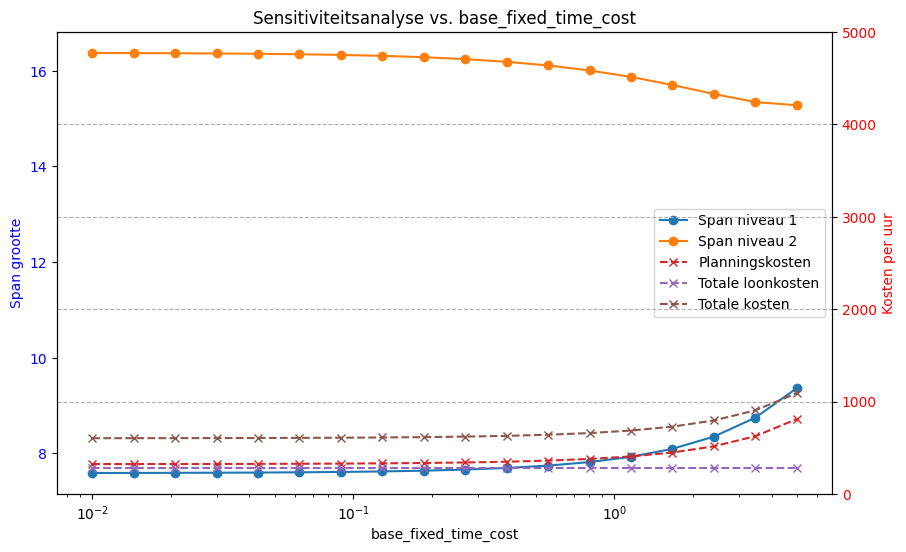

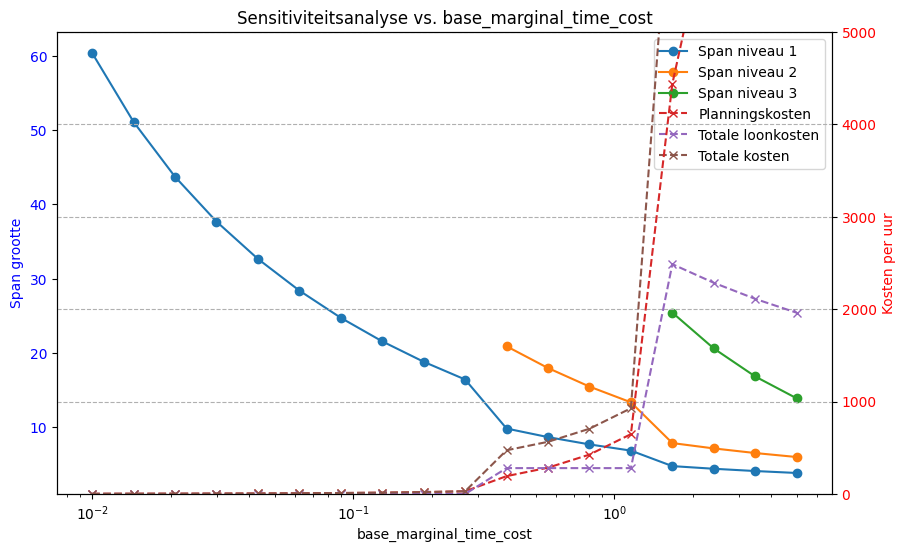

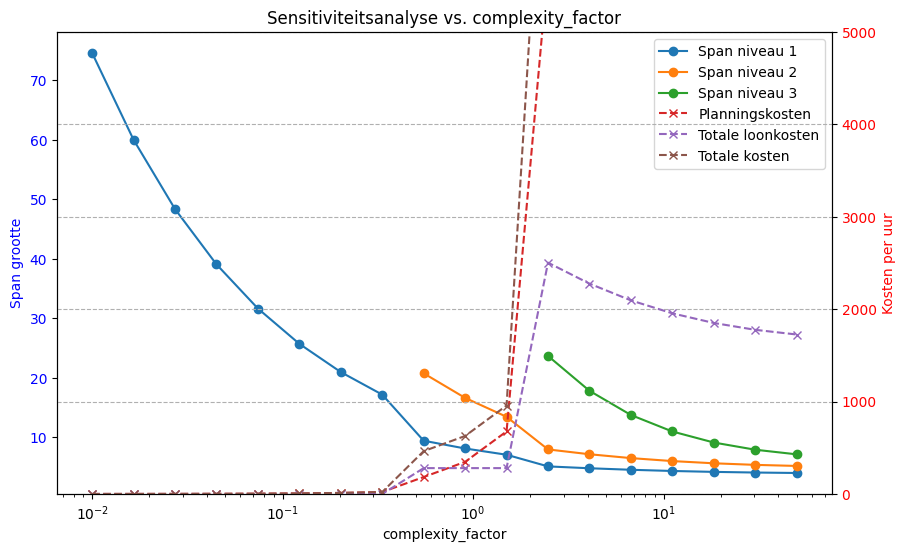

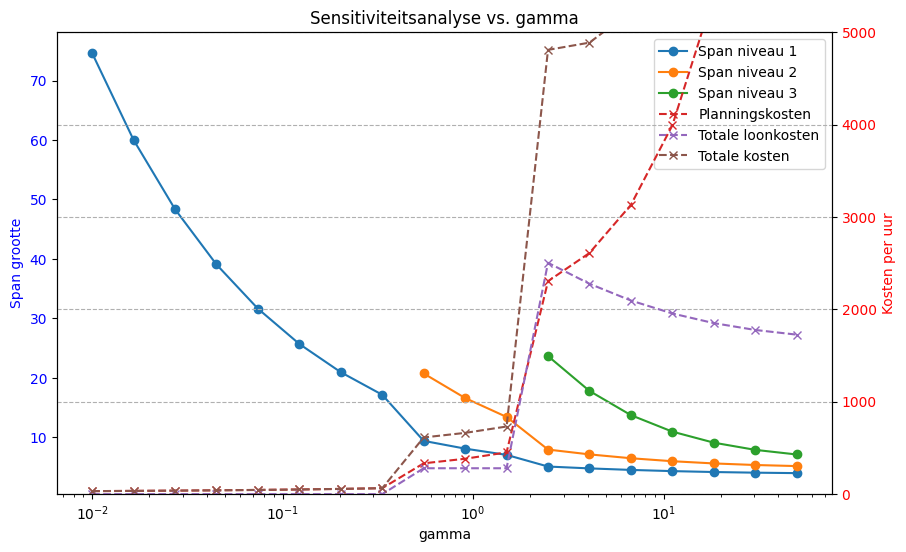

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Functies uit het eerdere model:
# -------------------------------
def solve_for_s1(a, beta, tol=1e-6, max_iter=100):
    s = math.e  
    for i in range(max_iter):
        f = s * (math.log(s) - 1) - (a + beta)
        df = math.log(s)
        if abs(df) < tol:
            break
        s_new = s - f/df
        if abs(s_new - s) < tol:
            return s_new
        s = s_new
    return s

def compute_hierarchy_structure(N, a, beta, fixed_time_cost, marginal_time_cost):
    s_levels = []  
    x_levels = []  
    x1 = 1
    x_levels.append(x1)
    s1 = solve_for_s1(a, beta)
    s_levels.append(s1)
    
    x_next = x1 * s1
    level = 1
    while x_next < N:
        s_prev = s_levels[-1]
        x_prev = x_levels[-1]
        s_t = s_prev + (1 + a * x_prev)
        s_levels.append(s_t)
        x_next = x_levels[-1] * s_t
        x_levels.append(x_next)
        level += 1
        if level > 20:
            break
    T = len(s_levels)
    return s_levels, x_levels, T

def compute_total_planning_time(s_levels, fixed_time_cost, marginal_time_cost):
    total_time = sum(fixed_time_cost + marginal_time_cost * s for s in s_levels)
    return total_time

def compute_total_wage_cost(x_levels, wage_cost):
    total_managers = sum(x_levels[:-1])
    return wage_cost * total_managers

def calculate_detailed_optimal_hierarchy(N, wage_cost, base_fixed_time_cost, base_marginal_time_cost,
                                         complexity_factor, gamma=1.0, tol=1e-4, max_iter=50):
    fixed_time_cost = base_fixed_time_cost * complexity_factor
    marginal_time_cost = base_marginal_time_cost * complexity_factor
    beta = fixed_time_cost / marginal_time_cost
    a = 0.1  
    for iteration in range(max_iter):
        s_levels, x_levels, T = compute_hierarchy_structure(N, a, beta, fixed_time_cost, marginal_time_cost)
        Y_T = compute_total_planning_time(s_levels, fixed_time_cost, marginal_time_cost)
        a_new = wage_cost / (2 * gamma * Y_T)
        if abs(a_new - a) < tol:
            a = a_new
            break
        a = (a + a_new) / 2.0

    planning_cost = gamma * (Y_T**2)
    wage_cost_total = compute_total_wage_cost(x_levels, wage_cost)
    total_cost = planning_cost + wage_cost_total

    return {
        'a': a,
        's_levels': s_levels,
        'x_levels': x_levels,
        'T': T,
        'total_planning_time': Y_T,
        'planning_cost': planning_cost,  # Toegevoegd: planningskosten
        'total_wage_cost': wage_cost_total,
        'total_cost': total_cost
    }

def sensitivity_analysis(param_name, param_values, default_params):
    results = []
    for val in param_values:
        params = default_params.copy()
        params[param_name] = val
        res = calculate_detailed_optimal_hierarchy(
            N=params['N'],
            wage_cost=params['wage_cost'],
            base_fixed_time_cost=params['base_fixed_time_cost'],
            base_marginal_time_cost=params['base_marginal_time_cost'],
            complexity_factor=params['complexity_factor'],
            gamma=params['gamma'],
            tol=1e-4,
            max_iter=50
        )
        # Voeg de onderzochte parameterwaarde toe aan het resultaat (optioneel)
        res[param_name] = val
        results.append(res)
    return results

# -------------------------------
# Instellingen voor de sensitiviteitsanalyse:
# -------------------------------
default_params = {
    'N': 75,                          # Aantal productieve eenheden
    'wage_cost': 280,                   # Loonkosten per medewerker (€/ planningcyclus)
    'base_fixed_time_cost': 1,         # Basis vaste tijdskost per niveau (tijd die een manager zeker bezig is met coördineren, ongeacht van het aantal volk, per planningcyclus)
    'base_marginal_time_cost': 0.75,      # Basis marginale tijdskost per ondergeschikte (coördineringstijd, afhankelijk van het aantal volk)
    'complexity_factor': 1,            # Complexiteitsfactor M
    'gamma': 1.0                     # Coëfficiënt in de planningkostfunctie
}

# Originele bereikwaarden
orig_param_ranges = {
    'N': [2, 3, 4, 5, 5.5, 6, 6.5, 7, 10, 200],
    'wage_cost': [10, 20, 25, 30, 35, 40, 45, 50, 100, 1000],
    'base_fixed_time_cost': [0.01, 0.05, 0.1, 0.5, 1, 5],
    'base_marginal_time_cost': [0.01, 0.05, 0.1, 0.5, 1, 5],
    'complexity_factor': [0.01, 0.1, 0.5, 1, 5, 50],
    'gamma': [0.01, 0.1, 0.5, 1.0, 5.0, 50]
}

# -------------------------------
# Combineren van alle informatie in 1 grafiek per te onderzoeken parameter:
# -------------------------------
for param, orig_values in orig_param_ranges.items():
    # Genereer drie keer zoveel punten in log-schaal
    new_points = np.logspace(np.log10(min(orig_values)), np.log10(max(orig_values)), num=len(orig_values)*3)
    # Voor 'N' willen we gehele getallen
    if param == 'N':
        new_points = np.unique(np.round(new_points).astype(int))
    # Gebruik de dense punten als de te onderzoeken waarden
    values = new_points

    results = sensitivity_analysis(param, values, default_params)
    
    # Bepaal het maximum aantal niveaus (voor de span-grootte per niveau)
    max_levels = max(res['T'] for res in results)
    span_matrix = np.full((max_levels, len(values)), np.nan)
    for j, res in enumerate(results):
        for i, span in enumerate(res['s_levels']):
            span_matrix[i, j] = span

    # Verkrijg de kosten/tijd informatie
    planning_costs = [res['planning_cost'] for res in results]
    wage_costs = [res['total_wage_cost'] for res in results]
    total_costs = [res['total_cost'] for res in results]

    # Maak een figuur met twee y-assen
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Linker y-as: span-groottes per niveau
    for i in range(max_levels):
        ax1.plot(values, span_matrix[i, :], marker='o', label=f"Span niveau {i+1}")
    ax1.set_xscale('log')
    ax1.set_xlabel(param)
    ax1.set_ylabel("Span grootte", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Rechter y-as: kosten (planningskosten, loonkosten en totale kosten)
    ax2 = ax1.twinx()
    ax2.plot(values, planning_costs, marker='x', linestyle='--', color='C3', label="Planningskosten")
    ax2.plot(values, wage_costs, marker='x', linestyle='--', color='C4', label="Totale loonkosten")
    ax2.plot(values, total_costs, marker='x', linestyle='--', color='C5', label="Totale kosten")
    ax2.set_ylabel("Kosten per uur", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    # Stel de limiet van de kosten in op maximaal 5000
    ax2.set_ylim(0, 5000)
    
    # Combineer de legendes van beide assen
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title(f"Sensitiviteitsanalyse vs. {param}")
    plt.grid(True, which="both", ls="--")
    plt.show()


## Wage multiplier toegevoegd

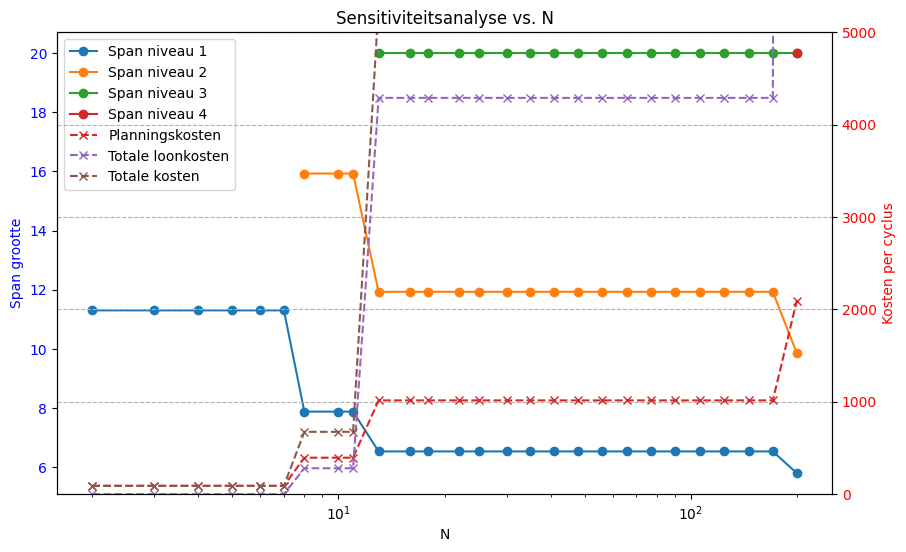

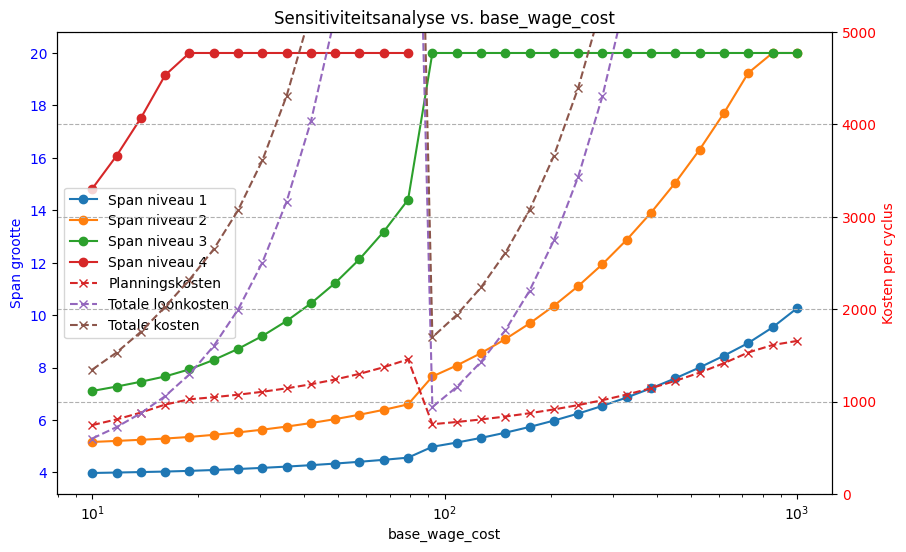

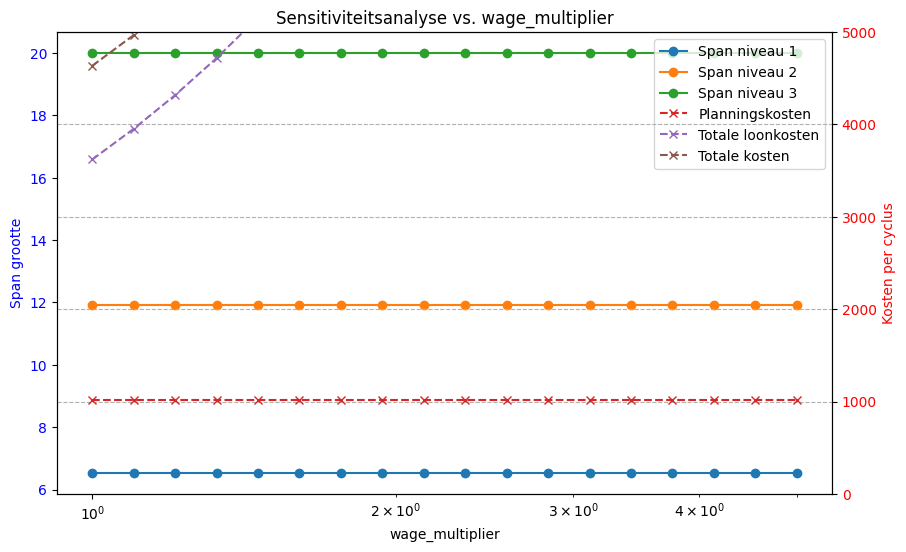

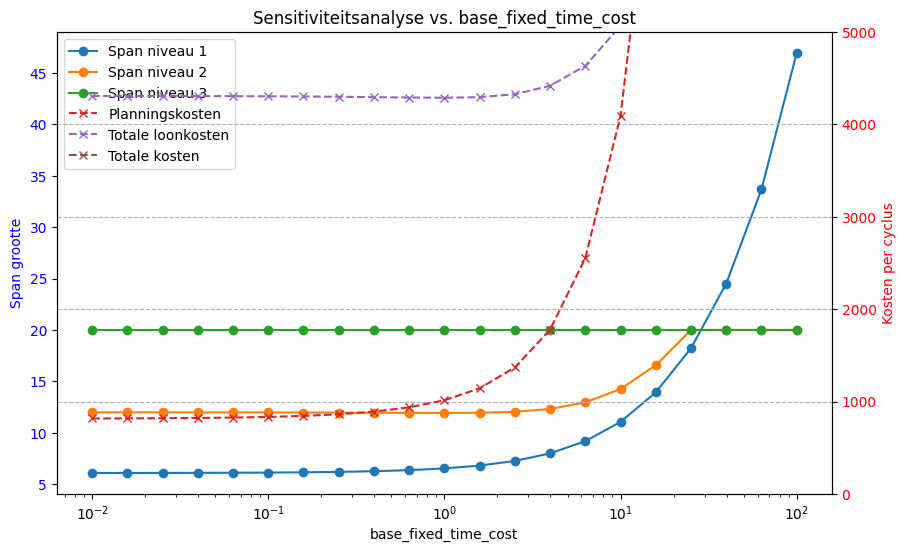

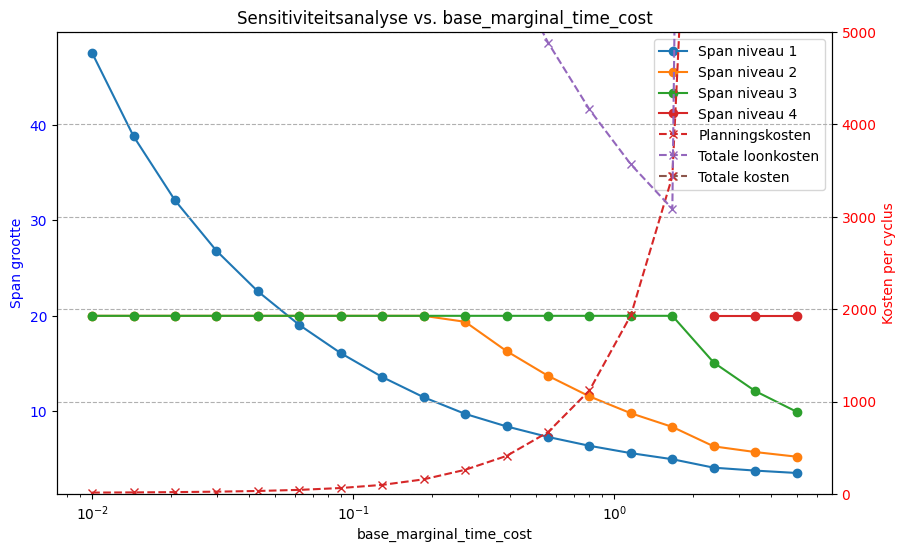

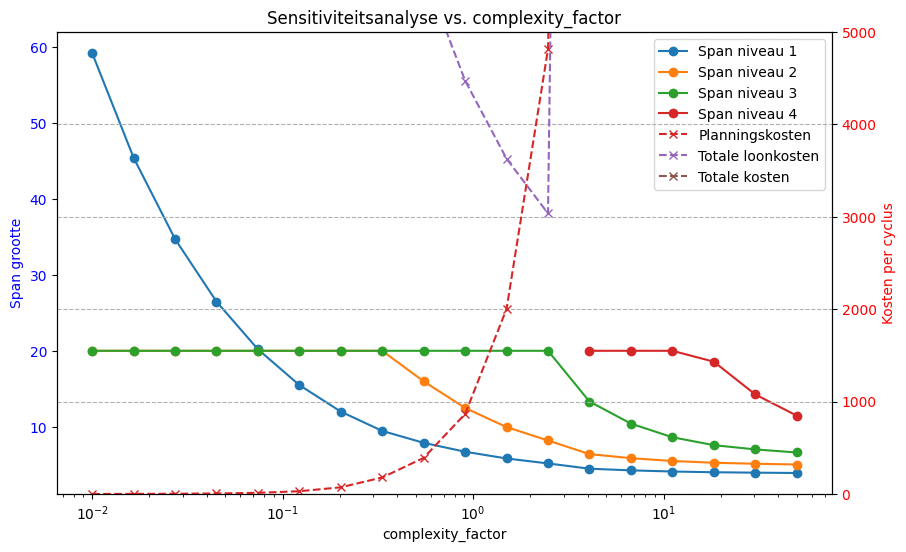

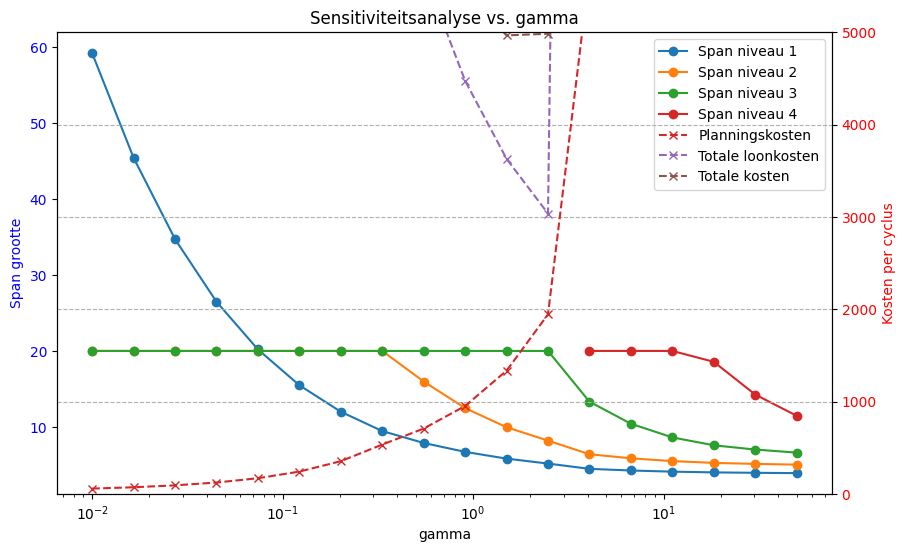

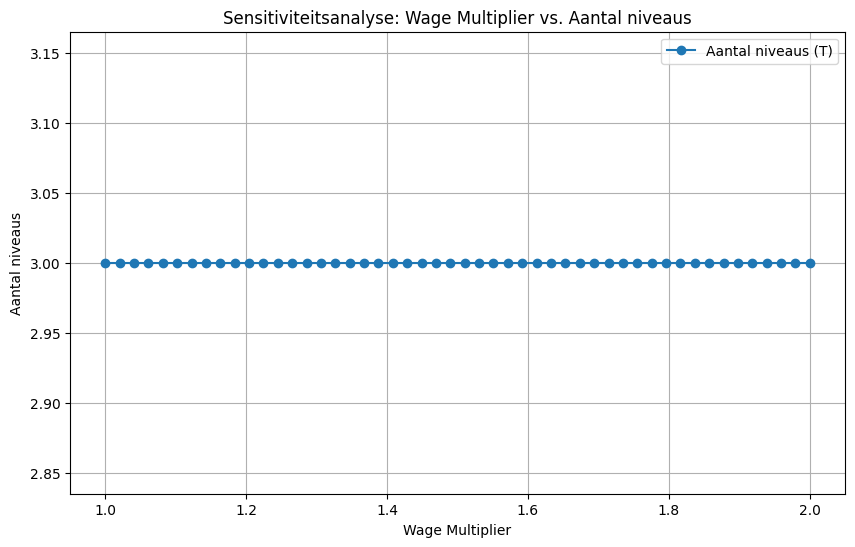

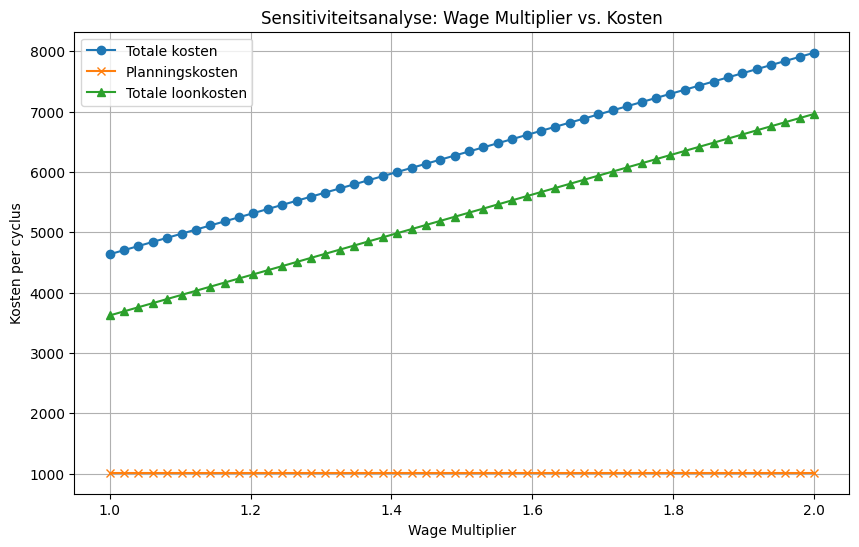

In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt

def solve_for_s1(a, beta, tol=1e-6, max_iter=100):
    s = math.e  
    for i in range(max_iter):
        f = s * (math.log(s) - 1) - (a + beta)
        df = math.log(s)
        if abs(df) < tol:
            break
        s_new = s - f/df
        if abs(s_new - s) < tol:
            return s_new
        s = s_new
    return s

def compute_hierarchy_structure(N, a, beta, fixed_time_cost, marginal_time_cost):
    s_levels = []  
    x_levels = []  
    x1 = 1
    x_levels.append(x1)
    s1 = solve_for_s1(a, beta)
    s_levels.append(s1)
    
    x_next = x1 * s1
    level = 1
    while x_next < N:
        s_prev = s_levels[-1]
        x_prev = x_levels[-1]
        s_t = s_prev + (1 + a * x_prev)
        s_t = min(s_t, 20)  # Voeg hier de beperking toe: maximum span van 20
        s_levels.append(s_t)
        x_next = x_prev * s_t
        x_levels.append(x_next)
        level += 1
        if level > 20:
            break
    T = len(s_levels)
    return s_levels, x_levels, T


def compute_total_planning_time(s_levels, fixed_time_cost, marginal_time_cost):
    total_time = sum(fixed_time_cost + marginal_time_cost * s for s in s_levels)
    return total_time

def compute_total_wage_cost_by_level(x_levels, base_wage_cost, wage_multiplier):
    """
    Bereken de totale loonkosten per niveau.
    Voor niveau t geldt: loon = base_wage_cost * (wage_multiplier)^(t-1)
    en dit wordt vermenigvuldigd met het aantal managers op dat niveau.
    We tellen de niveaus tot T-1 (zoals in het oorspronkelijke model).
    """
    total_cost = 0
    for i in range(len(x_levels)-1):
        level_wage = base_wage_cost * (wage_multiplier ** i)
        total_cost += x_levels[i] * level_wage
    return total_cost

def calculate_detailed_optimal_hierarchy(N, base_wage_cost, wage_multiplier, base_fixed_time_cost, base_marginal_time_cost,
                                         complexity_factor, gamma=1.0, tol=1e-4, max_iter=50):
    """
    Berekent de optimale hiërarchische structuur met een iteratief algoritme.
    
    Input:
      N: Aantal productieve eenheden.
      base_wage_cost: Basis loonkost per medewerker op niveau 1.
      wage_multiplier: Factor waarmee de loonkosten per niveau stijgen.
      base_fixed_time_cost: Basis vaste tijdskosten per niveau.
      base_marginal_time_cost: Basis marginale tijdskosten per ondergeschikte.
      complexity_factor: De complexiteitsfactor.
      gamma: Coëfficiënt in de planningkostfunctie.
      tol: Tolerantie voor convergentie.
      
    Output:
      Een dictionary met:
        - 'a': Geconvergeerde waarde van a.
        - 's_levels': Lijst met optimale span per niveau.
        - 'x_levels': Lijst met aantal managers per niveau.
        - 'T': Aantal niveaus.
        - 'total_planning_time': Totale planningstijd.
        - 'planning_cost': Totale planningskosten.
        - 'total_wage_cost': Totale loonkosten van de hiërarchie.
        - 'total_cost': Totale kosten (planning + loonkosten).
    """
    fixed_time_cost = base_fixed_time_cost * complexity_factor
    marginal_time_cost = base_marginal_time_cost * complexity_factor
    beta = fixed_time_cost / marginal_time_cost
    a = 0.1  
    for iteration in range(max_iter):
        s_levels, x_levels, T = compute_hierarchy_structure(N, a, beta, fixed_time_cost, marginal_time_cost)
        Y_T = compute_total_planning_time(s_levels, fixed_time_cost, marginal_time_cost)
        a_new = base_wage_cost / (2 * gamma * Y_T)  # Update op basis van de basis loonkost
        if abs(a_new - a) < tol:
            a = a_new
            break
        a = (a + a_new) / 2.0

    planning_cost = gamma * (Y_T**2)
    wage_cost_total = compute_total_wage_cost_by_level(x_levels, base_wage_cost, wage_multiplier)
    total_cost = planning_cost + wage_cost_total

    return {
        'a': a,
        's_levels': s_levels,
        'x_levels': x_levels,
        'T': T,
        'total_planning_time': Y_T,
        'planning_cost': planning_cost,
        'total_wage_cost': wage_cost_total,
        'total_cost': total_cost
    }

def sensitivity_analysis(param_name, param_values, default_params):
    results = []
    for val in param_values:
        params = default_params.copy()
        params[param_name] = val
        res = calculate_detailed_optimal_hierarchy(
            N=params['N'],
            base_wage_cost=params['base_wage_cost'],
            wage_multiplier=params['wage_multiplier'],
            base_fixed_time_cost=params['base_fixed_time_cost'],
            base_marginal_time_cost=params['base_marginal_time_cost'],
            complexity_factor=params['complexity_factor'],
            gamma=params['gamma'],
            tol=1e-4,
            max_iter=50
        )
        res[param_name] = val
        results.append(res)
    return results

# Voorbeeldinstellingen voor de sensitiviteitsanalyse:
default_params = {
    'N': 100,                          # Aantal productieve eenheden
    'base_wage_cost': 280,            # Basis loonkost per medewerker op niveau 1 (per planningcyclus)
    'wage_multiplier': 1.2,           # Factor waarmee de loonkosten per niveau stijgen
    'base_fixed_time_cost': 1,         # Basis vaste tijdskost per niveau
    'base_marginal_time_cost': 0.75,    # Basis marginale tijdskost per ondergeschikte
    'complexity_factor': 1,            # Complexiteitsfactor
    'gamma': 1.0                     # Coëfficiënt in de planningkostfunctie
}

orig_param_ranges = {
    'N': [2, 3, 4, 5, 5.5, 6, 6.5, 7, 10, 200],
    'base_wage_cost': [10, 20, 25, 30, 35, 40, 45, 50, 100, 1000],
    'wage_multiplier': [1.0, 1.1, 1.2, 1.5, 2, 5],
    'base_fixed_time_cost': [0.01, 0.05, 0.1, 0.5, 1, 5, 100],
    'base_marginal_time_cost': [0.01, 0.05, 0.1, 0.5, 1, 5],
    'complexity_factor': [0.01, 0.1, 0.5, 1, 5, 50],
    'gamma': [0.01, 0.1, 0.5, 1.0, 5.0, 50]
}

# ---------------------------
# Algemene sensitiviteitsanalyse (voor alle parameters)
# ---------------------------
for param, orig_values in orig_param_ranges.items():
    new_points = np.logspace(np.log10(min(orig_values)), np.log10(max(orig_values)), num=len(orig_values)*3)
    if param == 'N':
        new_points = np.unique(np.round(new_points).astype(int))
    values = new_points

    results = sensitivity_analysis(param, values, default_params)
    
    max_levels = max(res['T'] for res in results)
    span_matrix = np.full((max_levels, len(values)), np.nan)
    for j, res in enumerate(results):
        for i, span in enumerate(res['s_levels']):
            span_matrix[i, j] = span

    planning_costs = [res['planning_cost'] for res in results]
    wage_costs = [res['total_wage_cost'] for res in results]
    total_costs = [res['total_cost'] for res in results]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    for i in range(max_levels):
        ax1.plot(values, span_matrix[i, :], marker='o', label=f"Span niveau {i+1}")
    ax1.set_xscale('log')
    ax1.set_xlabel(param)
    ax1.set_ylabel("Span grootte", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(values, planning_costs, marker='x', linestyle='--', color='C3', label="Planningskosten")
    ax2.plot(values, wage_costs, marker='x', linestyle='--', color='C4', label="Totale loonkosten")
    ax2.plot(values, total_costs, marker='x', linestyle='--', color='C5', label="Totale kosten")
    ax2.set_ylabel("Kosten per cyclus", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 5000)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title(f"Sensitiviteitsanalyse vs. {param}")
    plt.grid(True, which="both", ls="--")
    plt.show()

# ---------------------------
# Extra sensitiviteitsanalyse specifiek voor de wage_multiplier
# ---------------------------
# Definieer een fijnmaziger bereik voor wage_multiplier (bijv. 1.0 tot 2.0)
multiplier_values = np.linspace(1.0, 2.0, 50)
results_multiplier = sensitivity_analysis('wage_multiplier', multiplier_values, default_params)

# Extra outputs voor deze analyse:
T_levels = [res['T'] for res in results_multiplier]
total_costs_mult = [res['total_cost'] for res in results_multiplier]
planning_costs_mult = [res['planning_cost'] for res in results_multiplier]
wage_costs_mult = [res['total_wage_cost'] for res in results_multiplier]

# Plot: Aantal niveaus (T) vs. wage_multiplier
plt.figure(figsize=(10, 6))
plt.plot(multiplier_values, T_levels, marker='o', label="Aantal niveaus (T)")
plt.xlabel("Wage Multiplier")
plt.ylabel("Aantal niveaus")
plt.title("Sensitiviteitsanalyse: Wage Multiplier vs. Aantal niveaus")
plt.legend()
plt.grid(True)
plt.show()

# Plot: Kosten vs. wage_multiplier
plt.figure(figsize=(10, 6))
plt.plot(multiplier_values, total_costs_mult, marker='o', label="Totale kosten")
plt.plot(multiplier_values, planning_costs_mult, marker='x', label="Planningskosten")
plt.plot(multiplier_values, wage_costs_mult, marker='^', label="Totale loonkosten")
plt.xlabel("Wage Multiplier")
plt.ylabel("Kosten per cyclus")
plt.title("Sensitiviteitsanalyse: Wage Multiplier vs. Kosten")
plt.legend()
plt.grid(True)
plt.show()


With lagrangian constraint, using scipy's minimize solver

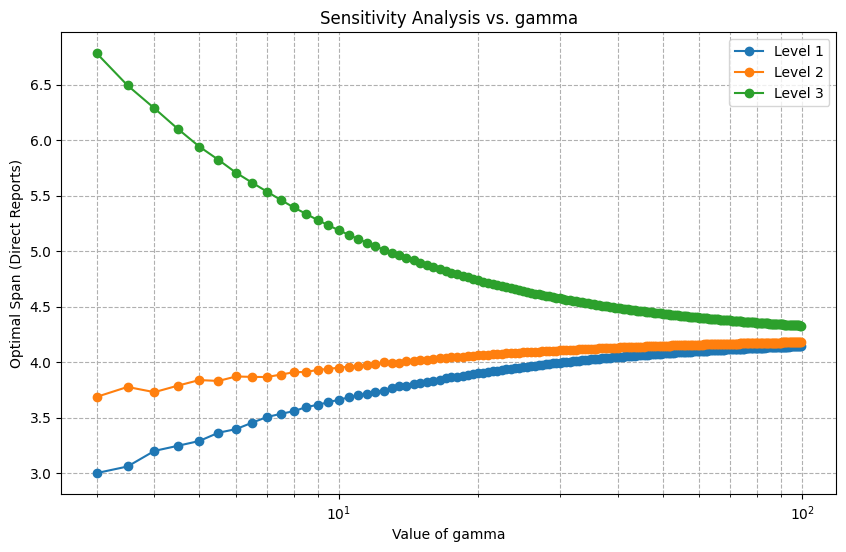

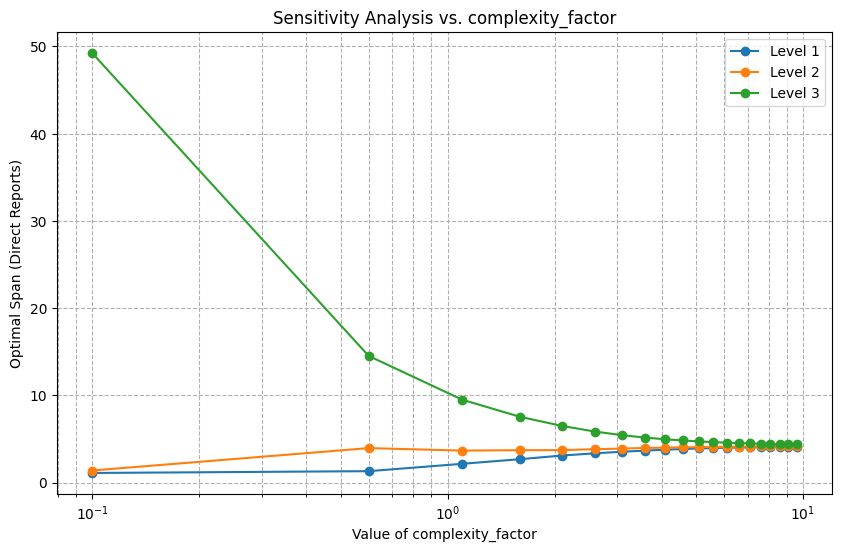

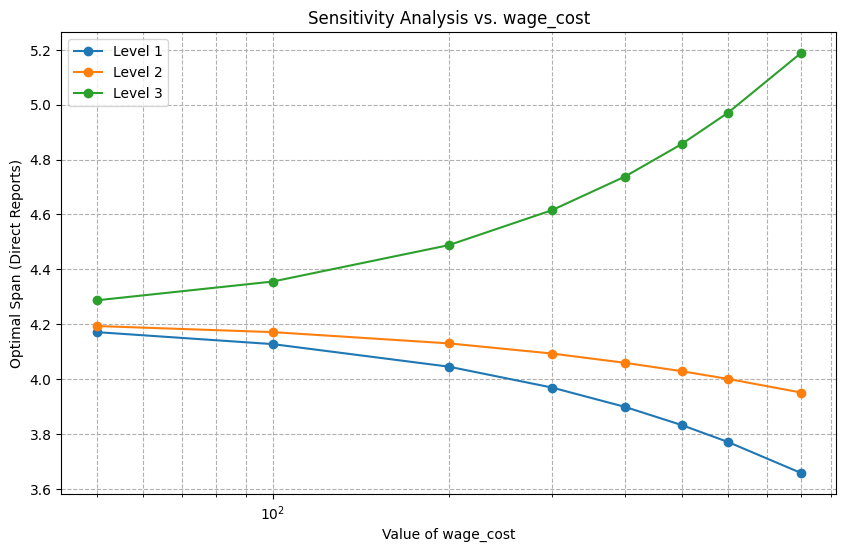

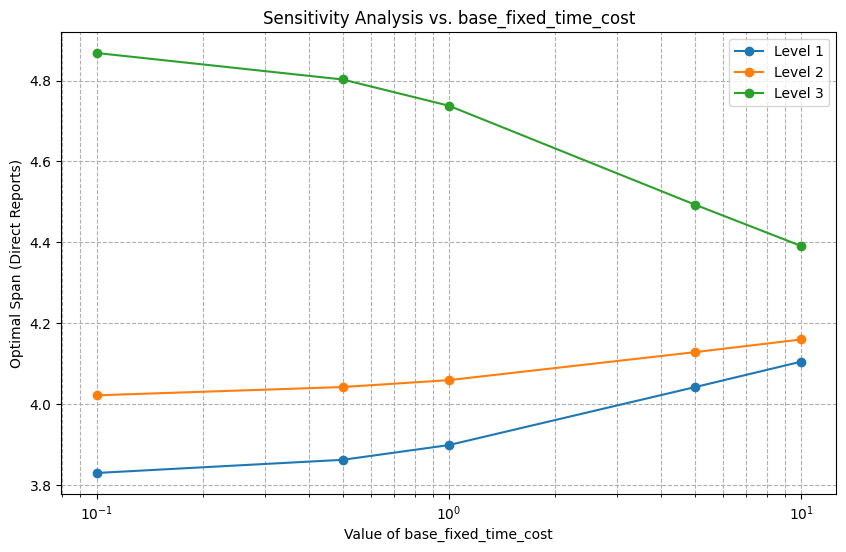

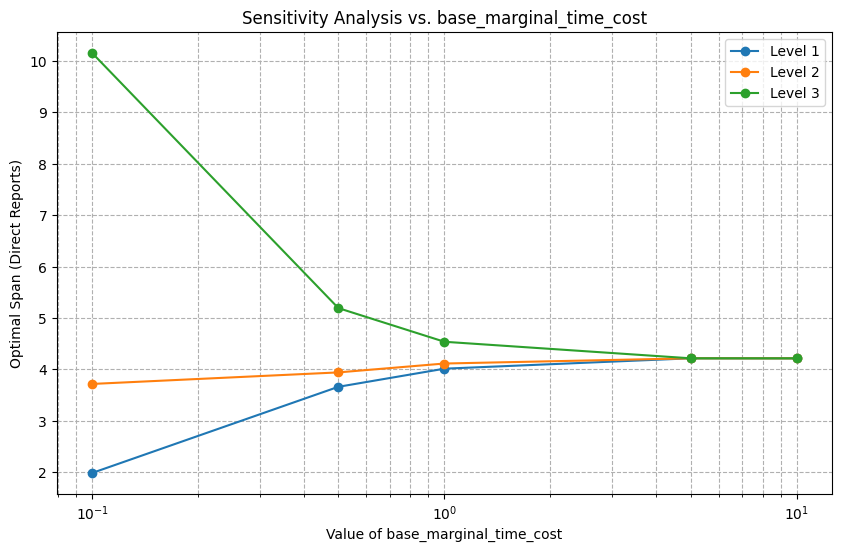

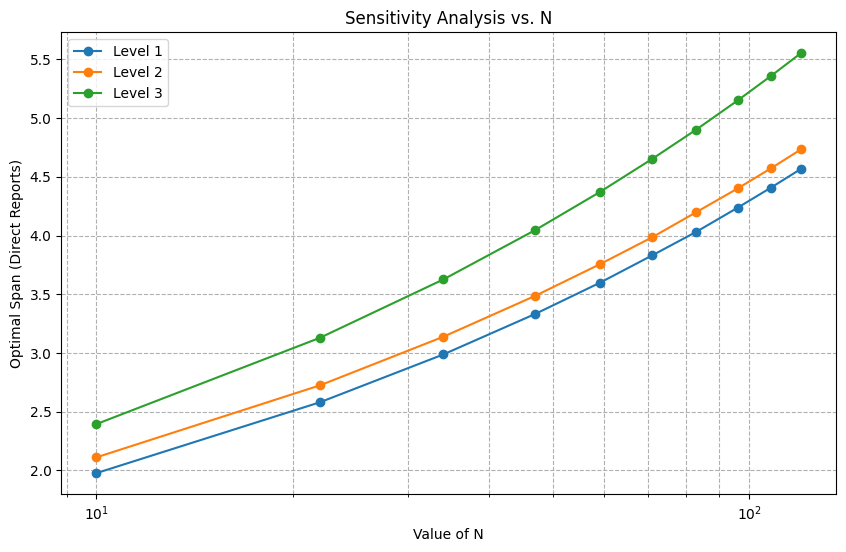

Grid Search over gamma and complexity_factor:
Gamma =  3.0, Complexity =  0.1 -> Levels: 3, Span sizes: [ 1.1    1.1   61.983], Product = 75.00, x-levels: [ 1.    1.1   1.21 75.  ]
Gamma =  3.0, Complexity =  0.6 -> Levels: 3, Span sizes: [ 1.1    2.919 23.349], Product = 75.00, x-levels: [ 1.     1.1    3.212 75.   ]
Gamma =  3.0, Complexity =  1.1 -> Levels: 3, Span sizes: [ 1.1    3.707 18.393], Product = 75.00, x-levels: [ 1.     1.1    4.078 75.   ]
Gamma =  3.0, Complexity =  1.6 -> Levels: 3, Span sizes: [ 1.335  3.942 14.255], Product = 75.00, x-levels: [ 1.     1.335  5.261 75.   ]
Gamma =  3.0, Complexity =  2.1 -> Levels: 3, Span sizes: [ 1.676  3.786 11.818], Product = 75.00, x-levels: [ 1.     1.676  6.346 75.   ]
Gamma =  3.0, Complexity =  2.6 -> Levels: 3, Span sizes: [ 1.981  3.693 10.251], Product = 75.00, x-levels: [ 1.     1.981  7.316 75.   ]
Gamma =  3.0, Complexity =  3.1 -> Levels: 3, Span sizes: [2.243 3.681 9.084], Product = 75.00, x-levels: [ 1.     2.243  8.

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ========================================
# 1. Functies voor optimalisatie met penalty
# ========================================

def compute_x_levels(s):
    """
    Bereken de cumulatieve managers (x-levels) gegeven de spans s.
    x[0] = 1; vervolgens geldt: x[t] = x[t-1] * s[t-1].
    """
    x = [1.0]
    for si in s:
        x.append(x[-1] * si)
    return np.array(x)

def planning_time(s, fixed_time_cost, marginal_time_cost):
    """
    Bereken de totale planningstijd als de som over niveaus:
    Y_T = sum(fixed_time_cost + marginal_time_cost * s_t)
    """
    return np.sum(fixed_time_cost + marginal_time_cost * s)

def total_wage_cost(x, wage_cost):
    """
    Bereken de totale loonkost over de managementniveaus (alleen de managers, niet de operationele units).
    """
    # x bevat de cumulatieve aantallen; de laatste waarde hoort bij de productieve units.
    return wage_cost * np.sum(x[:-1])

def objective(s, gamma, wage_cost, fixed_time_cost, marginal_time_cost, lambda_pen, N):
    """
    Doelstelling met penalty:
      - Kosten door planningstijd: gamma * (Y_T)^2.
      - Wage costs: wage_cost * sum(x (exclusief laatste niveau)).
      - Straf voor afwijking van de constraint (product(s) ≈ N).
    """
    x = compute_x_levels(s)
    Y_T = planning_time(s, fixed_time_cost, marginal_time_cost)
    cost_planning = gamma * (Y_T ** 2)
    cost_wage = total_wage_cost(x, wage_cost)
    penalty = lambda_pen * (np.prod(s) - N) ** 2
    return cost_planning + cost_wage + penalty

def optimize_hierarchy(T, gamma, wage_cost, fixed_time_cost, marginal_time_cost, lambda_pen, N):
    """
    Optimaliseer de vector s (spans per niveau) voor een gegeven vast aantal niveaus T.
    """
    # Beginwaarde: bijvoorbeeld 3 voor elk niveau
    s0 = np.array([3.0] * T)
    # Spans moeten minimaal iets boven 1 liggen (anders geen management)
    bounds = [(1.1, None) for _ in range(T)]
    res = minimize(objective, s0, args=(gamma, wage_cost, fixed_time_cost, marginal_time_cost, lambda_pen, N),
                   bounds=bounds, method='L-BFGS-B')
    s_opt = res.x
    x_opt = compute_x_levels(s_opt)
    prod_s = np.prod(s_opt)
    return s_opt, x_opt, prod_s

# ========================================
# 2. Sensitiviteitsanalyse en Plotfuncties
# ========================================

def sensitivity_analysis(param_name, param_values, default_params, T, lambda_pen):
    """
    Voer voor elke waarde in param_values de optimalisatie uit en verzamel de resultaten.
    """
    results = []
    for val in param_values:
        params = default_params.copy()
        params[param_name] = val
        fixed_tc = params['base_fixed_time_cost'] * params['complexity_factor']
        marginal_tc = params['base_marginal_time_cost'] * params['complexity_factor']
        s_opt, x_opt, prod_s = optimize_hierarchy(
            T, params['gamma'], params['wage_cost'],
            fixed_tc, marginal_tc, lambda_pen, params['N']
        )
        results.append({
            'param_value': val,
            's_opt': s_opt,
            'x_opt': x_opt,
            'prod_s': prod_s
        })
    return results

def plot_sensitivity_results(results, param_name):
    """
    Plot voor elk managementniveau de optimale span als functie van de gevarieerde parameter.
    """
    T = len(results[0]['s_opt'])
    vals = [res['param_value'] for res in results]
    # Maak een matrix waarbij elke rij overeenkomt met een niveau (optimal s)
    span_matrix = np.array([res['s_opt'] for res in results])
    
    plt.figure(figsize=(10, 6))
    for level in range(T):
        plt.plot(vals, span_matrix[:, level], marker='o', label=f"Level {level+1}")
    plt.xlabel(f"Value of {param_name}")
    plt.ylabel("Optimal Span (Direct Reports)")
    plt.xscale('log')
    plt.legend(loc='best')
    plt.title(f"Sensitivity Analysis vs. {param_name}")
    plt.grid(True, which="both", ls="--")
    plt.show()

# ========================================
# 3. Default instellingen
# ========================================
T = 3  # Aantal managementniveaus (vast)
default_params = {
    'N': 75,  # Aantal productieve eenheden (operationele units)
    'wage_cost': 400,  # Uniforme wage cost (indien geen differentiatie per niveau)
    'base_fixed_time_cost': 1,  # Basis vaste tijdskost per niveau (uren)
    'base_marginal_time_cost': 0.75,  # Basis marginale tijdskost per ondergeschikte (uren)
    'complexity_factor': 5,  # Schaalfactor voor de tijdskosten
    'gamma': 20.0  # Coëfficiënt in de planningkostfunctie
}
lambda_pen = 1e6  # Penalty-parameter (moet groot genoeg zijn om de constraint te handhaven)

# ========================================
# 4. Uitvoeren van sensitiviteitsanalyses voor verschillende parameters
# ========================================

# Voor gamma:
gamma_values = np.arange(3, 100, 0.5)
results_gamma = sensitivity_analysis('gamma', gamma_values, default_params, T, lambda_pen)
plot_sensitivity_results(results_gamma, 'gamma')

# Voor de complexity factor:
complexity_values = np.arange(0.1, 10.1, 0.5)
results_complexity = sensitivity_analysis('complexity_factor', complexity_values, default_params, T, lambda_pen)
plot_sensitivity_results(results_complexity, 'complexity_factor')

# Voor wage_cost (bijvoorbeeld):
wage_cost_values = [50, 100, 200, 300, 400, 500, 600, 800]
results_wage = sensitivity_analysis('wage_cost', wage_cost_values, default_params, T, lambda_pen)
plot_sensitivity_results(results_wage, 'wage_cost')

# Voor base_fixed_time_cost:
fixed_time_values = [0.1, 0.5, 1, 5, 10]
results_fixed = sensitivity_analysis('base_fixed_time_cost', fixed_time_values, default_params, T, lambda_pen)
plot_sensitivity_results(results_fixed, 'base_fixed_time_cost')

# Voor base_marginal_time_cost:
marginal_time_values = [0.1, 0.5, 1, 5, 10]
results_marginal = sensitivity_analysis('base_marginal_time_cost', marginal_time_values, default_params, T, lambda_pen)
plot_sensitivity_results(results_marginal, 'base_marginal_time_cost')

# Voor N:
N_values = np.unique(np.round(np.linspace(10, 120, 10)).astype(int))
results_N = sensitivity_analysis('N', N_values, default_params, T, lambda_pen)
plot_sensitivity_results(results_N, 'N')

# ========================================
# 5. Grid Search over meerdere parameters (bijv. gamma en complexity_factor)
# ========================================
print("Grid Search over gamma and complexity_factor:")
for g in gamma_values:
    for comp in complexity_values:
        fixed_tc = default_params['base_fixed_time_cost'] * comp
        marginal_tc = default_params['base_marginal_time_cost'] * comp
        s_opt, x_opt, prod_s = optimize_hierarchy(T, g, default_params['wage_cost'], fixed_tc, marginal_tc, lambda_pen, default_params['N'])
        print(f"Gamma = {g:4.1f}, Complexity = {comp:4.1f} -> Levels: {T}, "
              f"Span sizes: {np.round(s_opt, 3)}, Product = {prod_s:.2f}, x-levels: {np.round(x_opt,3)}")
    print("-" * 60)


Bottom teams, already allocated, as input

Optimale hiërarchische structuur (automatische keuze van n1):
Bottom teams (niveau 0): [10, 14, 11, 8, 16, 7, 9]
Optimaal aantal managers op niveau 1 (n1): 4
Gegroepeerde loads op niveau 1: [24, 19, 23, 9]
Discrete spans op niveau 1 (aantal teams per manager): [2, 2, 2, 1]
Optimale spans voor upper levels (niveaus 2 en hoger): [1.901 2.104]
X-levels voor upper levels: [1.    1.901 3.999]
Totale planningsduur (management): 120.01738640277438
Totale loonkosten (management): 2760.400456310266
Planning cost: 288083.46077905706
Totale kosten: 290843.8612353673


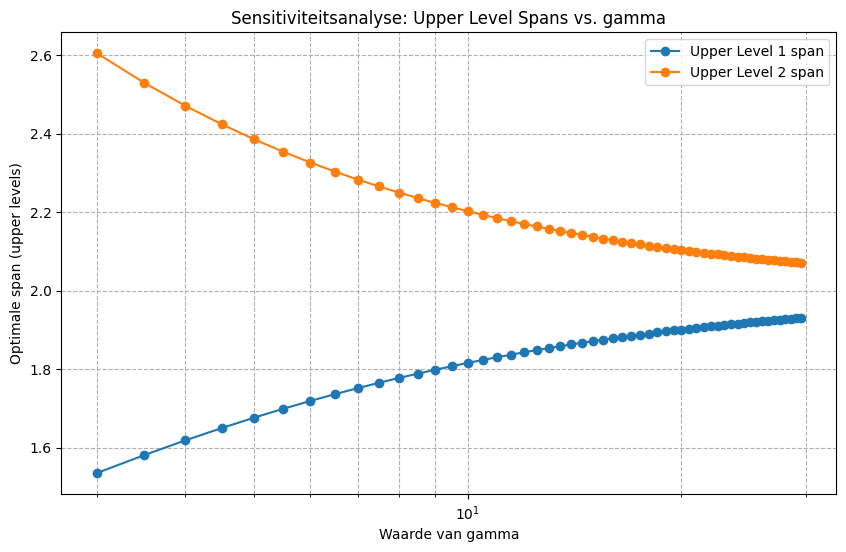

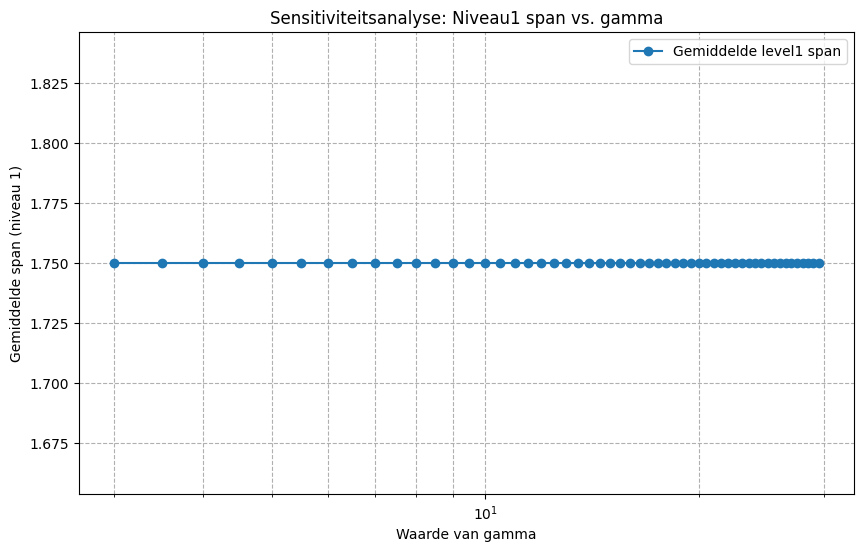

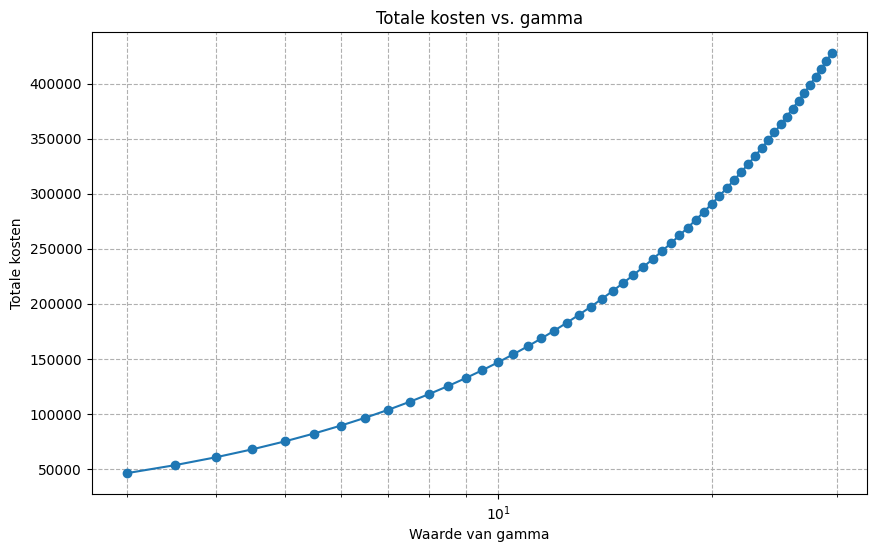

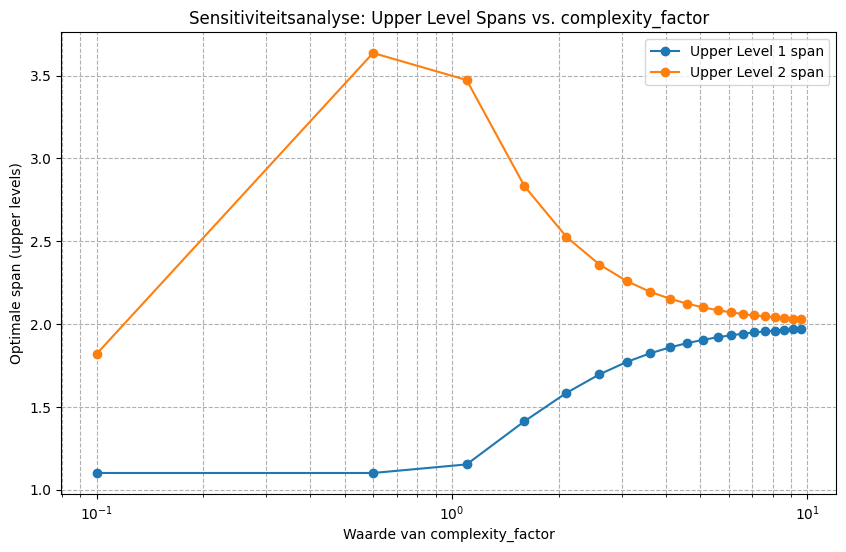

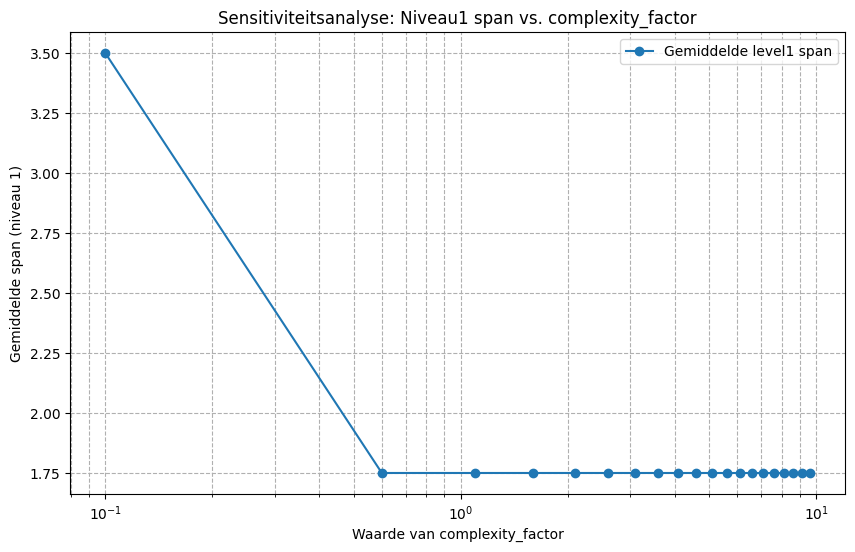

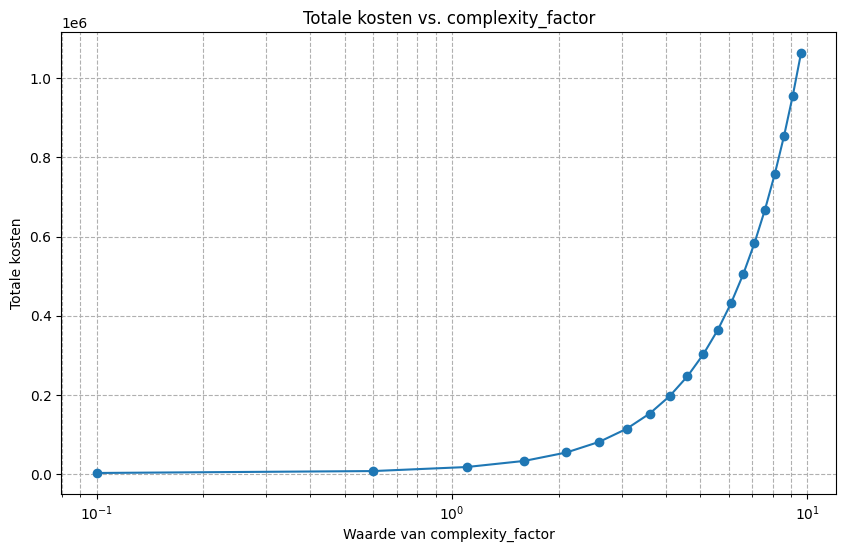

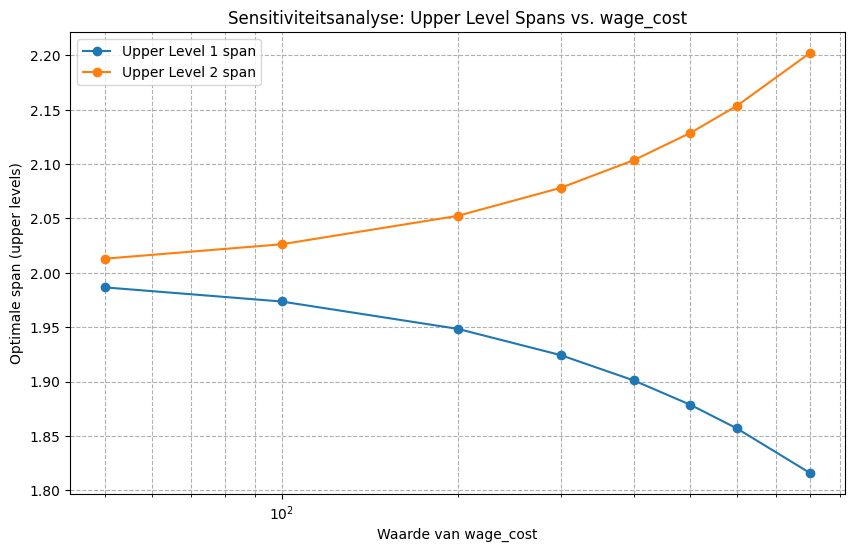

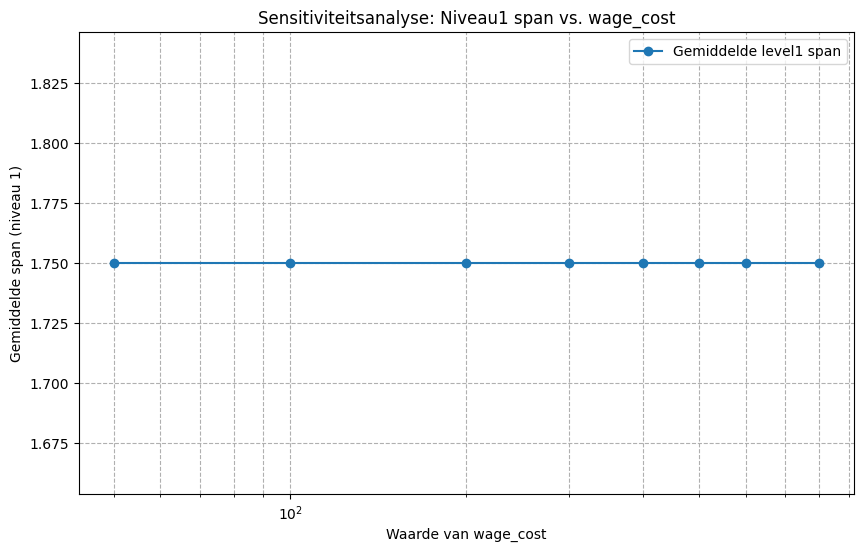

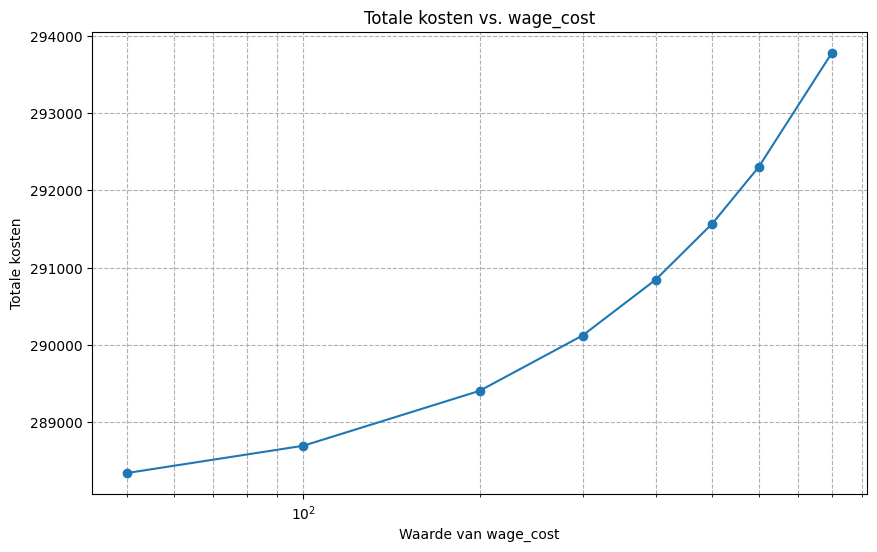

In [1]:
        import math
        import numpy as np
        import matplotlib.pyplot as plt
        from scipy.optimize import minimize

        # ========================================
        # Deel 1: Basisfuncties en optimalisatie (upper levels)
        # ========================================

        def compute_x_levels(s):
            """
            Bereken de cumulatieve managers (x-levels) gegeven de spans s.
            x[0] = 1; daarna: x[t] = x[t-1] * s[t-1].
            """
            x = [1.0]
            for si in s:
                x.append(x[-1] * si)
            return np.array(x)

        def planning_time(s, fixed_time_cost, marginal_time_cost):
            """
            Bereken de totale planningstijd als de som over niveaus:
            Y_T = sum(fixed_time_cost + marginal_time_cost * s_t)
            """
            return np.sum(fixed_time_cost + marginal_time_cost * s)

        def total_wage_cost(x, wage_cost):
            """
            Bereken de totale loonkost over de managementniveaus (alleen de managers).
            """
            return wage_cost * np.sum(x[:-1])

        def objective(s, gamma, wage_cost, fixed_time_cost, marginal_time_cost, lambda_pen, N_eff):
            """
            Doelstelling met penalty:
            - Planningkost: gamma * (Y_T)^2.
            - Loonkosten: wage_cost * sum(x (exclusief laatste niveau)).
            - Straf (penalty): (np.prod(s) - N_eff)^2.
            """
            x = compute_x_levels(s)
            Y_T = planning_time(s, fixed_time_cost, marginal_time_cost)
            cost_planning = gamma * (Y_T ** 2)
            cost_wage = total_wage_cost(x, wage_cost)
            penalty = lambda_pen * (np.prod(s) - N_eff) ** 2
            return cost_planning + cost_wage + penalty

        def optimize_upper_levels(T_upper, gamma, wage_cost, fixed_time_cost, marginal_time_cost, lambda_pen, N_eff):
            """
            Optimaliseer de vector s voor de upper levels (boven niveau 1).
            T_upper: aantal niveaus boven de eerste.
            Constraint: product(s) ≈ N_eff (dat is hier n₁).
            """
            s0 = np.array([3.0] * T_upper)
            bounds = [(1.1, None)] * T_upper
            res = minimize(objective, s0, args=(gamma, wage_cost, fixed_time_cost, marginal_time_cost, lambda_pen, N_eff),
                        bounds=bounds, method='L-BFGS-B')
            s_opt = res.x
            x_opt = compute_x_levels(s_opt)
            prod_s = np.prod(s_opt)
            return s_opt, x_opt, prod_s

        # ========================================
        # Deel 2: Groeperen van de bottom teams (niveau 1) met discrete spans
        # ========================================

        def group_units_custom_with_counts(loads, num_groups):
            """
            Deel de lijst 'loads' (teamgroottes) in 'num_groups' groepen.
            Retourneer zowel de som van de loads per groep als het aantal teams (de span).
            """
            total = sum(loads)
            target = total / num_groups
            groups = []
            counts = []
            current_group = []
            current_sum = 0
            for load in loads:
                current_group.append(load)
                current_sum += load
                if current_sum >= target and len(groups) < num_groups - 1:
                    groups.append(sum(current_group))
                    counts.append(len(current_group))
                    current_group = []
                    current_sum = 0
            if current_group:
                groups.append(sum(current_group))
                counts.append(len(current_group))
            return groups, counts

        def compute_level1_cost(bottom_teams, n1, fixed_time_cost, marginal_time_cost, wage_cost):
            """
            Gegeven bottom teams (lijst met teamgroottes) en een voorgestelde waarde n1 (aantal managers op niveau 1),
            bereken:
            - De groepering van teams: zowel de som van de loads als de count (aantal teams per manager).
            - De planningstijd per manager op dit niveau: fixed_time_cost + marginal_time_cost * (load).
            - De effectieve planningstijd is de maximumtijd over alle managers.
            - De loonkosten op niveau 1.
            """
            groups, counts = group_units_custom_with_counts(bottom_teams, n1)
            planning_times = [fixed_time_cost + marginal_time_cost * group for group in groups]
            level1_planning_time = max(planning_times)
            level1_wage_cost = wage_cost * n1
            return groups, counts, level1_planning_time, level1_wage_cost

        # ========================================
        # Deel 3: Gecombineerd model met automatische keuze van n1
        # ========================================

        def calculate_optimal_hierarchy_with_bottom_teams(bottom_teams, n1, T_total, gamma, wage_cost,
                                                        base_fixed_time_cost, base_marginal_time_cost, 
                                                        complexity_factor, lambda_pen):
            """
            Bereken de volledige hiërarchie wanneer de bottom teams expliciet worden ingegeven.
            
            Input:
            - bottom_teams: lijst met teamgroottes op niveau 0 (bv. [10,14,11,8,16,7,9])
            - n1: voorgestelde waarde voor het aantal managers op niveau 1.
            - T_total: totaal aantal managementniveaus (inclusief niveau 1).
            - gamma, wage_cost, base_fixed_time_cost, base_marginal_time_cost, complexity_factor: modelparameters.
            - lambda_pen: penalty-parameter.
            """
            fixed_time_cost = base_fixed_time_cost * complexity_factor
            marginal_time_cost = base_marginal_time_cost * complexity_factor

            # Niveau 1: groeperen van bottom teams
            groups, level1_counts, level1_time, level1_wage = compute_level1_cost(bottom_teams, n1, fixed_time_cost, marginal_time_cost, wage_cost)
            # Bepaal hier de discrete spans op niveau 1 (aantal teams per manager)
            level1_spans = level1_counts

            N_eff = n1  # effectief aantal eenheden voor upper levels
            T_upper = T_total - 1

            if T_upper > 0:
                s_opt_upper, x_opt_upper, prod_s_upper = optimize_upper_levels(T_upper, gamma, wage_cost,
                                                                                fixed_time_cost, marginal_time_cost,
                                                                                lambda_pen, N_eff)
                Y_upper = planning_time(s_opt_upper, fixed_time_cost, marginal_time_cost)
                wage_upper = total_wage_cost(x_opt_upper, wage_cost)
            else:
                s_opt_upper = np.array([])
                x_opt_upper = np.array([N_eff])
                prod_s_upper = None
                Y_upper = 0.0
                wage_upper = 0.0

            total_planning_time = level1_time + Y_upper
            total_wage_cost_total = level1_wage + wage_upper

            planning_cost = gamma * (total_planning_time ** 2)
            total_cost = planning_cost + total_wage_cost_total

            result = {
                'bottom_teams': bottom_teams,
                'n1': n1,
                'groups': groups,
                'level1_spans': level1_spans,  # discrete spans op niveau 1 (aantal teams per manager)
                'level1_planning_time': level1_time,
                'level1_wage_cost': level1_wage,
                's_upper': s_opt_upper,          # optimale spans voor upper levels (continue waarden)
                'x_upper': x_opt_upper,
                'prod_s_upper': prod_s_upper,
                'upper_levels_planning_time': Y_upper,
                'upper_levels_wage_cost': wage_upper,
                'total_planning_time': total_planning_time,
                'planning_cost': planning_cost,
                'total_wage_cost': total_wage_cost_total,
                'total_cost': total_cost,
                'T_total': T_total,
                'T_upper': T_upper,
                'effective_N': N_eff
            }
            return result

        def optimize_n1(bottom_teams, T_total, gamma, wage_cost, base_fixed_time_cost, base_marginal_time_cost,
                        complexity_factor, lambda_pen):
            """
            Doorloop alle mogelijke waarden voor n1 (van 1 tot len(bottom_teams)) en kies de hiërarchie met de laagste totale kosten.
            """
            possible_results = []
            for n1 in range(1, len(bottom_teams)+1):
                res = calculate_optimal_hierarchy_with_bottom_teams(
                    bottom_teams, n1, T_total, gamma, wage_cost,
                    base_fixed_time_cost, base_marginal_time_cost, complexity_factor, lambda_pen
                )
                res['n1'] = n1
                possible_results.append(res)
            optimal_result = min(possible_results, key=lambda r: r['total_cost'])
            return optimal_result, possible_results

        # ========================================
        # Deel 4: Sensitiviteitsanalyse
        # ========================================

        def sensitivity_analysis_bottom_teams(param_name, param_values, default_params, bottom_teams, T_total, lambda_pen):
            """
            Voer voor elke waarde in param_values de volledige hiërarchieberekening uit (inclusief optimale n1)
            en verzamel de resultaten.
            """
            results = []
            for val in param_values:
                params = default_params.copy()
                params[param_name] = val
                optimal, _ = optimize_n1(bottom_teams, T_total, params['gamma'], params['wage_cost'],
                                        params['base_fixed_time_cost'], params['base_marginal_time_cost'],
                                        params['complexity_factor'], lambda_pen)
                optimal[param_name] = val
                results.append(optimal)
            return results

        def plot_sensitivity_results_bottom_teams(results, param_name):
            """
            Plot de optimale spans voor de upper levels als functie van de gevarieerde parameter.
            """
            if results[0]['T_upper'] > 0:
                T_upper = len(results[0]['s_upper'])
                vals = [res[param_name] for res in results]
                span_matrix = np.array([res['s_upper'] for res in results])
            
                plt.figure(figsize=(10, 6))
                for level in range(T_upper):
                    plt.plot(vals, span_matrix[:, level], marker='o', label=f"Upper Level {level+1} span")
                plt.xlabel(f"Waarde van {param_name}")
                plt.ylabel("Optimale span (upper levels)")
                plt.xscale('log')
                plt.legend(loc="best")
                plt.title(f"Sensitiviteitsanalyse: Upper Level Spans vs. {param_name}")
                plt.grid(True, which="both", ls="--")
                plt.show()
            else:
                print("Geen upper levels, dus geen sensitiviteitsplot voor upper spans.")

        def plot_level1_spans(results, param_name):
            """
            Plot de gemiddelde (of alle) discrete spans op niveau 1 als functie van de gevarieerde parameter.
            """
            vals = [res[param_name] for res in results]
            # Omdat niveau 1 spans per resultaat een lijst kan zijn, berekenen we hier het gemiddelde per resultaat.
            level1_avg_spans = [np.mean(res['level1_spans']) for res in results]
            plt.figure(figsize=(10, 6))
            plt.plot(vals, level1_avg_spans, marker='o', label="Gemiddelde level1 span")
            plt.xlabel(f"Waarde van {param_name}")
            plt.ylabel("Gemiddelde span (niveau 1)")
            plt.xscale('log')
            plt.legend(loc="best")
            plt.title(f"Sensitiviteitsanalyse: Niveau1 span vs. {param_name}")
            plt.grid(True, which="both", ls="--")
            plt.show()

        def plot_total_cost(results, param_name):
            """
            Plot de totale kosten als functie van de gevarieerde parameter.
            """
            vals = [res[param_name] for res in results]
            costs = [res['total_cost'] for res in results]
            plt.figure(figsize=(10, 6))
            plt.plot(vals, costs, marker='o')
            plt.xlabel(f"Waarde van {param_name}")
            plt.ylabel("Totale kosten")
            plt.xscale('log')
            plt.title(f"Totale kosten vs. {param_name}")
            plt.grid(True, which="both", ls="--")
            plt.show()

        # ========================================
        # Deel 5: Default instellingen en voorbeelduitvoering
        # ========================================

        # Voorbeeld bottom teams (niveau 0)
        bottom_teams = [10, 14, 11, 8, 16, 7, 9]

        # Totaal aantal managementniveaus (inclusief niveau 1)
        T_total = 3

        # Overige modelparameters (zoals in je oorspronkelijke model)
        default_params = {
            'wage_cost': 400,
            'base_fixed_time_cost': 1,
            'base_marginal_time_cost': 0.75,
            'complexity_factor': 5,
            'gamma': 20.0,
            'N': 75  # Niet gebruikt nu, want we werken met bottom teams.
        }
        lambda_pen = 1e6

        # Bereken de optimale hiërarchie met automatische keuze voor n1
        optimal_result, all_results = optimize_n1(bottom_teams, T_total,
                                                gamma=default_params['gamma'],
                                                wage_cost=default_params['wage_cost'],
                                                base_fixed_time_cost=default_params['base_fixed_time_cost'],
                                                base_marginal_time_cost=default_params['base_marginal_time_cost'],
                                                complexity_factor=default_params['complexity_factor'],
                                                lambda_pen=lambda_pen)

        # Print de optimale uitkomst
        print("Optimale hiërarchische structuur (automatische keuze van n1):")
        print("Bottom teams (niveau 0):", optimal_result['bottom_teams'])
        print("Optimaal aantal managers op niveau 1 (n1):", optimal_result['n1'])
        print("Gegroepeerde loads op niveau 1:", optimal_result['groups'])
        print("Discrete spans op niveau 1 (aantal teams per manager):", optimal_result['level1_spans'])
        if optimal_result['T_upper'] > 0:
            print("Optimale spans voor upper levels (niveaus 2 en hoger):", np.round(optimal_result['s_upper'],3))
            print("X-levels voor upper levels:", np.round(optimal_result['x_upper'],3))
        else:
            print("Geen upper levels.")
        print("Totale planningsduur (management):", optimal_result['total_planning_time'])
        print("Totale loonkosten (management):", optimal_result['total_wage_cost'])
        print("Planning cost:", optimal_result['planning_cost'])
        print("Totale kosten:", optimal_result['total_cost'])

        # ========================================
        # Voorbeeld: Sensitiviteitsanalyse
        # ========================================

        # Variëren van gamma:
        gamma_values = np.arange(3, 30, 0.5)
        results_gamma = sensitivity_analysis_bottom_teams('gamma', gamma_values, default_params, bottom_teams, T_total, lambda_pen)
        plot_sensitivity_results_bottom_teams(results_gamma, 'gamma')
        plot_level1_spans(results_gamma, 'gamma')
        plot_total_cost(results_gamma, 'gamma')

        # Variëren van complexity_factor:
        complexity_values = np.arange(0.1, 10.1, 0.5)
        results_complexity = sensitivity_analysis_bottom_teams('complexity_factor', complexity_values, default_params, bottom_teams, T_total, lambda_pen)
        plot_sensitivity_results_bottom_teams(results_complexity, 'complexity_factor')
        plot_level1_spans(results_complexity, 'complexity_factor')
        plot_total_cost(results_complexity, 'complexity_factor')

        # Variëren van wage_cost:
        wage_cost_values = [50, 100, 200, 300, 400, 500, 600, 800]
        results_wage = sensitivity_analysis_bottom_teams('wage_cost', wage_cost_values, default_params, bottom_teams, T_total, lambda_pen)
        plot_sensitivity_results_bottom_teams(results_wage, 'wage_cost')
        plot_level1_spans(results_wage, 'wage_cost')
        plot_total_cost(results_wage, 'wage_cost')


1 manager per team

Optimale hiërarchische structuur (1 manager per bottom team):
Bottom teams (niveau 0): [9, 11, 9, 9]
Aantal managers op niveau 1 (n1): 4
Discrete spans op niveau 1 (altijd 1 per team): [1, 1, 1, 1]
Optimale spans voor upper levels: [1.879 2.128]
X-levels voor upper levels: [1.    1.879 3.999]
Totale planningsduur (management): 10.003644461756494
Totale loonkosten (management): 2826.8673590047956
Planning cost: 83060.50908930204
Totale kosten: 85887.37644830684


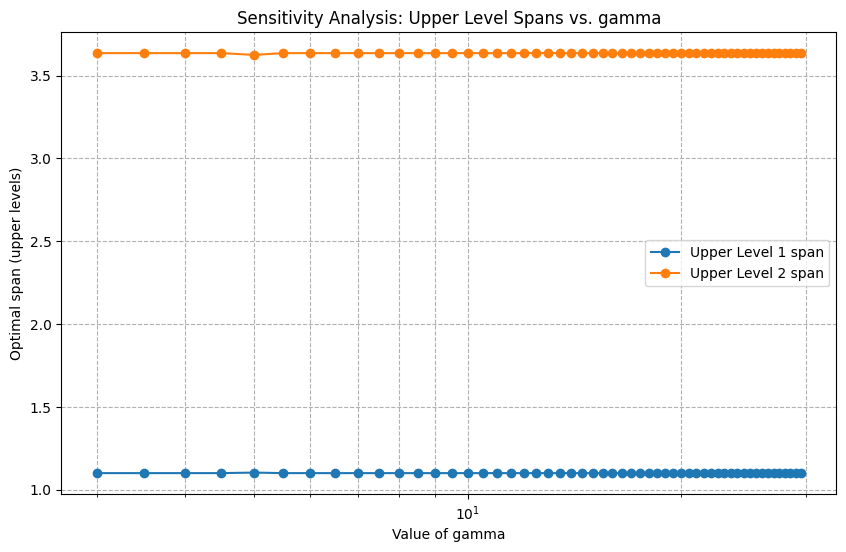

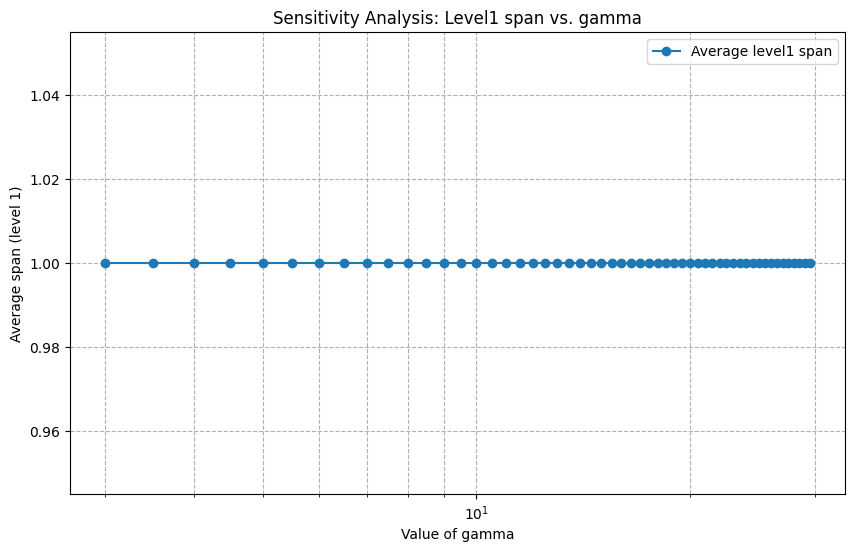

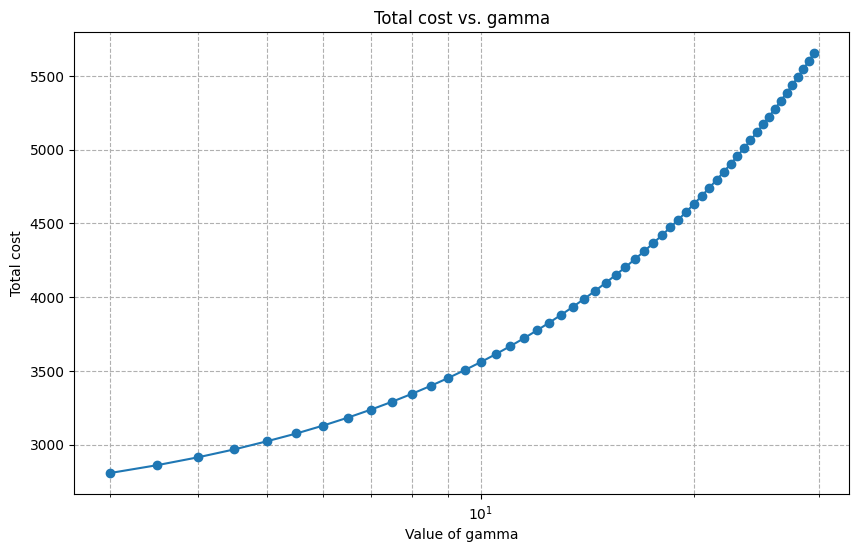

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ========================================
# Modelparameters
# ========================================
# Loonkoststijging per niveau (bijv. 10%)
increase_rate = 0.1

# ========================================
# Deel 1: Basisfuncties en optimalisatie (upper levels)
# ========================================

def compute_x_levels(s):
    """
    Bereken de cumulatieve managers (x-levels) gegeven de spans s.
    x[0] = 1; daarna: x[t] = x[t-1] * s[t-1].
    """
    x = [1.0]
    for si in s:
        x.append(x[-1] * si)
    return np.array(x)


def planning_time(s, fixed_time_cost, marginal_time_cost):
    """
    Bereken de totale planningstijd als de som over niveaus:
    Y_T = sum(fixed_time_cost + marginal_time_cost * s_t)
    """
    return np.sum(fixed_time_cost + marginal_time_cost * s)


def objective(s, gamma, wage_cost, increase_rate,
              fixed_time_cost, marginal_time_cost,
              lambda_pen, N_eff):
    """
    Doelstelling met penalty:
      - Planningkost: gamma * (Y_T)^2.
      - Loonkosten: wage_cost stijgend per niveau.
      - Straf (penalty): lambda_pen * (np.prod(s) - N_eff)^2.
    """
    x = compute_x_levels(s)
    Y_T = planning_time(s, fixed_time_cost, marginal_time_cost)

    cost_planning = gamma * (Y_T ** 2)
    # Loonkost per niveau, met toename per level
    cost_wage = sum(
        wage_cost * (1 + increase_rate)**j * x[j]
        for j in range(len(x)-1)
    )
    penalty = lambda_pen * (np.prod(s) - N_eff) ** 2
    return cost_planning + cost_wage + penalty


def optimize_upper_levels(T_upper, gamma, wage_cost, increase_rate,
                          fixed_time_cost, marginal_time_cost,
                          lambda_pen, N_eff):
    """
    Optimaliseer de vector s voor de upper levels (boven niveau 1).
    Constraint: product(s) ≈ N_eff.
    """
    s0 = np.array([3.0] * T_upper)
    bounds = [(1.1, None)] * T_upper
    res = minimize(
        objective, s0,
        args=(gamma, wage_cost, increase_rate,
              fixed_time_cost, marginal_time_cost,
              lambda_pen, N_eff),
        bounds=bounds, method='L-BFGS-B'
    )
    s_opt = res.x
    x_opt = compute_x_levels(s_opt)
    prod_s = np.prod(s_opt)
    return s_opt, x_opt, prod_s

# ========================================
# Deel 2: Groeperen van de bottom teams (niveau 1)
# ========================================

def compute_level1_cost(
    bottom_teams,
    fixed_time_cost,
    marginal_time_cost,
    wage_cost,
    uniform_load_value=10,
    increase_rate=0.1
):
    """
    Berekent planning en loonkosten voor niveau 1,
    met 1 manager per bottom team en vaste load.
    """
    n1 = len(bottom_teams)
    groups = [uniform_load_value] * n1
    planning_times = [fixed_time_cost + marginal_time_cost * load for load in groups]
    level1_planning_time = max(planning_times)
    # Loonkost op niveau 1 (factor (1+inc)^0)
    level1_wage_cost = wage_cost * (1 + increase_rate)**0 * n1
    return groups, [1]*n1, level1_planning_time, level1_wage_cost

# ========================================
# Deel 3: Gecombineerd model met vaste n1
# ========================================

def calculate_optimal_hierarchy_with_bottom_teams(
    bottom_teams,
    T_total,
    gamma,
    wage_cost,
    base_fixed_time_cost,
    base_marginal_time_cost,
    complexity_factor,
    lambda_pen,
    uniform_load_value=10,
    increase_rate=0.1
):
    """
    Volledig model met 1 manager per bottom team (n1 = len(bottom_teams)).
    """
    fixed_time_cost = base_fixed_time_cost * complexity_factor
    marginal_time_cost = base_marginal_time_cost * complexity_factor

    # Niveau 1: bottom teams
    n1 = len(bottom_teams)
    groups, level1_spans, level1_time, level1_wage = compute_level1_cost(
        bottom_teams,
        fixed_time_cost,
        marginal_time_cost,
        wage_cost,
        uniform_load_value,
        increase_rate
    )

    N_eff = n1
    T_upper = T_total - 1

    if T_upper > 0:
        s_opt_upper, x_opt_upper, prod_s_upper = optimize_upper_levels(
            T_upper,
            gamma,
            wage_cost,
            increase_rate,
            fixed_time_cost,
            marginal_time_cost,
            lambda_pen,
            N_eff
        )
        Y_upper = planning_time(s_opt_upper, fixed_time_cost, marginal_time_cost)
        wage_upper = sum(
            wage_cost * (1 + increase_rate)**j * x_opt_upper[j]
            for j in range(len(x_opt_upper)-1)
        )
    else:
        s_opt_upper = np.array([])
        x_opt_upper = np.array([N_eff])
        prod_s_upper = None
        Y_upper = 0.0
        wage_upper = 0.0

    total_planning_time = level1_time + Y_upper
    total_wage_cost_total = level1_wage + wage_upper
    planning_cost = gamma * (total_planning_time ** 2)
    total_cost = planning_cost + total_wage_cost_total

    return {
        'bottom_teams': bottom_teams,
        'n1': n1,
        'groups': groups,
        'level1_spans': level1_spans,
        'level1_planning_time': level1_time,
        'level1_wage_cost': level1_wage,
        's_upper': s_opt_upper,
        'x_upper': x_opt_upper,
        'prod_s_upper': prod_s_upper,
        'upper_levels_planning_time': Y_upper,
        'upper_levels_wage_cost': wage_upper,
        'total_planning_time': total_planning_time,
        'planning_cost': planning_cost,
        'total_wage_cost': total_wage_cost_total,
        'total_cost': total_cost,
        'T_total': T_total,
        'T_upper': T_upper,
        'effective_N': N_eff
    }

# ========================================
# Deel 4: Sensitiviteitsanalyse
# ========================================

def sensitivity_analysis_bottom_teams(
    param_name,
    param_values,
    default_params,
    bottom_teams,
    T_total,
    lambda_pen,
    uniform_load_value=10,
    increase_rate=0.1
):
    results = []
    for val in param_values:
        params = default_params.copy()
        params[param_name] = val
        optimal = calculate_optimal_hierarchy_with_bottom_teams(
            bottom_teams,
            T_total,
            params['gamma'],
            params['wage_cost'],
            params['base_fixed_time_cost'],
            params['base_marginal_time_cost'],
            params['complexity_factor'],
            lambda_pen,
            uniform_load_value,
            increase_rate
        )
        optimal[param_name] = val
        results.append(optimal)
    return results


def plot_sensitivity_results_bottom_teams(results, param_name):
    if results[0]['T_upper'] > 0:
        T_upper = len(results[0]['s_upper'])
        vals = [res[param_name] for res in results]
        span_matrix = np.array([res['s_upper'] for res in results])
        plt.figure(figsize=(10, 6))
        for level in range(T_upper):
            plt.plot(vals, span_matrix[:, level], marker='o', label=f"Upper Level {level+1} span")
        plt.xlabel(f"Value of {param_name}")
        plt.ylabel("Optimal span (upper levels)")
        plt.xscale('log')
        plt.legend(loc="best")
        plt.title(f"Sensitivity Analysis: Upper Level Spans vs. {param_name}")
        plt.grid(True, which="both", ls="--")
        plt.show()
    else:
        print("No upper levels, so no sensitivity plot for upper spans.")


def plot_level1_spans(results, param_name):
    vals = [res[param_name] for res in results]
    level1_avg_spans = [np.mean(res['level1_spans']) for res in results]
    plt.figure(figsize=(10, 6))
    plt.plot(vals, level1_avg_spans, marker='o', label="Average level1 span")
    plt.xlabel(f"Value of {param_name}")
    plt.ylabel("Average span (level 1)")
    plt.xscale('log')
    plt.legend(loc="best")
    plt.title(f"Sensitivity Analysis: Level1 span vs. {param_name}")
    plt.grid(True, which="both", ls="--")
    plt.show()


def plot_total_cost(results, param_name):
    vals = [res[param_name] for res in results]
    costs = [res['total_cost'] for res in results]
    plt.figure(figsize=(10, 6))
    plt.plot(vals, costs, marker='o')
    plt.xlabel(f"Value of {param_name}")
    plt.ylabel("Total cost")
    plt.xscale('log')
    plt.title(f"Total cost vs. {param_name}")
    plt.grid(True, which="both", ls="--")
    plt.show()

# ========================================
# Deel 5: Voorbeelduitvoering
# ========================================

if __name__ == "__main__":
    # Voorbeeld bottom teams (niveau 0)
    bottom_teams = [9, 11, 9, 9]
    T_total = 3

    default_params = {
        'wage_cost': 400,
        'base_fixed_time_cost': 1,
        'base_marginal_time_cost': 0.5,
        'complexity_factor': 1,
        'gamma': 830.0
    }
    lambda_pen = 1e6

    # Optimale hiërarchie
    optimal_result = calculate_optimal_hierarchy_with_bottom_teams(
        bottom_teams,
        T_total,
        gamma=default_params['gamma'],
        wage_cost=default_params['wage_cost'],
        base_fixed_time_cost=default_params['base_fixed_time_cost'],
        base_marginal_time_cost=default_params['base_marginal_time_cost'],
        complexity_factor=default_params['complexity_factor'],
        lambda_pen=lambda_pen,
        uniform_load_value=10,
        increase_rate=increase_rate
    )

    print("Optimale hiërarchische structuur (1 manager per bottom team):")
    print("Bottom teams (niveau 0):", optimal_result['bottom_teams'])
    print("Aantal managers op niveau 1 (n1):", optimal_result['n1'])
    print("Discrete spans op niveau 1 (altijd 1 per team):", optimal_result['level1_spans'])
    if optimal_result['T_upper'] > 0:
        print("Optimale spans voor upper levels:", np.round(optimal_result['s_upper'], 3))
        print("X-levels voor upper levels:", np.round(optimal_result['x_upper'], 3))
    else:
        print("Geen upper levels.")
    print("Totale planningsduur (management):", optimal_result['total_planning_time'])
    print("Totale loonkosten (management):", optimal_result['total_wage_cost'])
    print("Planning cost:", optimal_result['planning_cost'])
    print("Totale kosten:", optimal_result['total_cost'])

    # Sensitiviteitsanalyse voorbeeld
    gamma_values = np.arange(3, 30, 0.5)
    results_gamma = sensitivity_analysis_bottom_teams(
        'gamma', gamma_values, default_params, bottom_teams, T_total, lambda_pen,
        uniform_load_value=10, increase_rate=increase_rate
    )
    plot_sensitivity_results_bottom_teams(results_gamma, 'gamma')
    plot_level1_spans(results_gamma, 'gamma')
    plot_total_cost(results_gamma, 'gamma')
